# Proyek Klasifikasi Gambar "Cat & Dog"
- **Nama:** Ali Akbar Said
- **Email:** aliakbarsaid@gmail.com
- **ID Dicoding:** aasaid_18

## Import Semua Packages/Library yang Digunakan

In [1]:
# Install tensorflowjs untuk menyimpan model sebagai tfjs
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
from sklearn.model_selection import train_test_split
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import io
from google.colab import files

## Data Preparation

### Data Loading

In [3]:
# Upload kaggle.json
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0


In [4]:
# Ekstrak file cat-dog-images-for-classification.zip ke folder data
zip_file_path = "cat-dog-images-for-classification.zip"
extraction_path = "data"

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"File {zip_file_path} berhasil diekstrak ke folder {extraction_path}.")
except Exception as e:
    print(f"Terjadi kesalahan saat mengekstrak file: {e}")

# Load dataset dari data/cat_dog.csv ke dalam DataFrame
csv_file_path = os.path.join(extraction_path, "cat_dog.csv")
df = pd.read_csv(csv_file_path)

# Modifikasi kolom "image" pada DataFrame agar URL gambarnya lengkap
df['image'] = df['image'].apply(lambda x: os.path.join(extraction_path, "cat_dog", x))

# Konversi tipe data pada kolom "labels" menjadi string
df['labels'] = df['labels'].astype(str)

# Memeriksa file yang hilang
df = df[df['image'].apply(os.path.exists)]

# Menampilkan informasi tentang dataset
image_count = len(df)
label_counts = df['labels'].value_counts().to_dict()
print(f"Dataset: {image_count} images ({label_counts})")

File cat-dog-images-for-classification.zip berhasil diekstrak ke folder data.
Dataset: 25000 images ({'1': 12500, '0': 12500})


### Data Preprocessing

#### Split Dataset

In [5]:
# Memisahkan dataset menjadi train_df, val_df, dan test_df
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Definisi fungsi untuk menghasilkan generator data
def create_generator(df, augment=False):
    return ImageDataGenerator(
        rescale=1./255,
        **({'rotation_range': 20, 'horizontal_flip': True} if augment else {})
    ).flow_from_dataframe(
        dataframe=df,
        x_col='image',
        y_col='labels',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=augment
    )

# Menghasilkan generator untuk dataset pelatihan, validasi, dan pengujian
train_gen = create_generator(train_df, augment=True)
val_gen = create_generator(val_df)
test_gen = create_generator(test_df)

Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Modelling

In [6]:
# Membuat arsitektur model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Mengkompilasi model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 220ms/step - accuracy: 0.5771 - loss: 0.6707 - val_accuracy: 0.7072 - val_loss: 0.5713
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 208ms/step - accuracy: 0.6973 - loss: 0.5753 - val_accuracy: 0.7590 - val_loss: 0.4851
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 239ms/step - accuracy: 0.7428 - loss: 0.5206 - val_accuracy: 0.7736 - val_loss: 0.4752
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 216ms/step - accuracy: 0.7769 - loss: 0.4697 - val_accuracy: 0.8082 - val_loss: 0.4242
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - accuracy: 0.8027 - loss: 0.4326 - val_accuracy: 0.8282 - val_loss: 0.3843
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 210ms/step - accuracy: 0.8180 - loss: 0.4031 - val_accuracy: 0.8146 - val_loss: 0.4085
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 211ms/step - accuracy: 0.8331 - loss: 0.3806 - val_accuracy: 0.8458 - val_loss: 0.3457
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 217ms/step - accuracy: 0.8350 - los

## Evaluasi dan Visualisasi

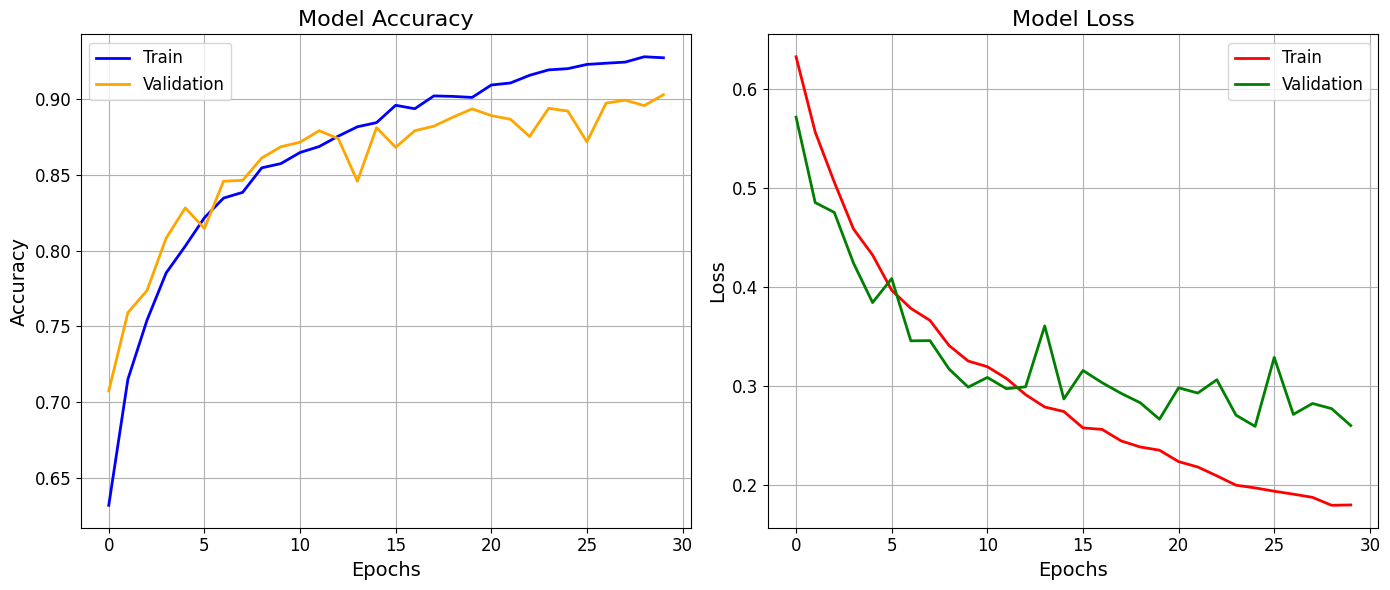

In [7]:
# Mengatur ukuran figure
plt.figure(figsize=(14, 6))

# Visualisasi Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linewidth=2)
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

# Visualisasi Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', color='green', linewidth=2)
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

# Menampilkan plot
plt.show()

In [8]:
# Menilai model

train_loss, train_acc = model.evaluate(train_gen)
print(f"Akurasi Data Latih: {train_acc:.2%}")

test_loss, test_acc = model.evaluate(test_gen)
print(f"Akurasi Data Uji: {test_acc:.2%}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 189ms/step - accuracy: 0.9383 - loss: 0.1505
Akurasi Data Latih: 94.18%
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8965 - loss: 0.2649
Akurasi Data Uji: 90.10%


## Konversi Model

In [9]:
# Menyimpan model sebagai savedmodel
tf.saved_model.save(model, 'saved_model')

In [10]:
# Menyimpan model sebagai tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

# Membuat file label.txt
with open('tflite/label.txt', 'w') as f:
    f.write("Cat\nDog\n")

Saved artifact at '/tmp/tmpmwsalp_3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136830111801296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111802064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111804944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111803216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111804368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111805712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111801488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111806096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111806480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136830111808016: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [11]:
# Menyimpan model sebagai tfjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-14 17:22:55.737627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744651375.758794   16019 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744651375.765037   16019 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-14 17:23:00.867201: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1744651380.867375   16019 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

Saving Gambar WhatsApp 2025-04-14 pukul 23.37.59_7545e1df.jpg to Gambar WhatsApp 2025-04-14 pukul 23.37.59_7545e1df.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


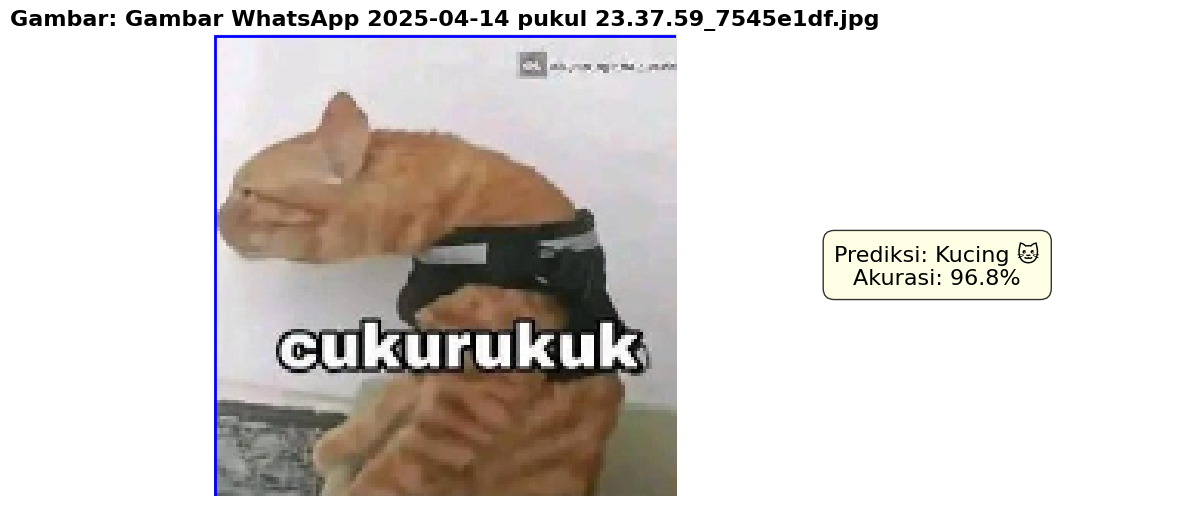


Hasil: Kucing 🐱 (96.8% akurat)


In [12]:
# Unggah gambar untuk diprediksi
uploaded = files.upload()

for filename in uploaded.keys():
    # Memproses gambar
    img_bytes = uploaded[filename]
    img = image.load_img(io.BytesIO(img_bytes), target_size=(150, 150))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    confidence = model.predict(img_array)[0][0]
    predicted_class = "Anjing 🐶" if confidence > 0.5 else "Kucing 🐱"
    confidence_pct = max(confidence, 1 - confidence) * 100

    # Menampilkan hasil
    plt.figure(figsize=(10, 5))

    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Gambar: {filename}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((0, 0), 150, 150, linewidth=2, edgecolor='blue', facecolor='none'))

    # Teks prediksi
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5,
             f"Prediksi: {predicted_class}\nAkurasi: {confidence_pct:.1f}%",
             fontsize=16,
             ha='center', va='center',
             bbox=dict(facecolor='lightyellow', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nHasil: {predicted_class} ({confidence_pct:.1f}% akurat)")

In [13]:
!pip freeze > requirements.txt

In [23]:
!zip -r tfjs_model.zip tfjs_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 6%)
  adding: tfjs_model/model.json (deflated 89%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 6%)
  adding: tfjs_model/.zip (stored 0%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 6%)
